In [2]:
import mujoco
import mujoco.viewer
import numpy as np
import time
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import csv
from plotly.subplots import make_subplots

In [48]:
class MuscleModel:
    def __init__(self, scale: float, wrist_on: bool = False, model_path: str = "model.xml", emg_muscles = []):
        self.scale = scale
        self.wrist_on = wrist_on
        self.model_path = model_path

        if self.wrist_on:
            self.muscle_names = []
            self.joint_names = []  
        else:
            # self.muscle_names = [
            #     "DELT1", "DELT2", "DELT3", "SUPSP", "INFSP", "SUBSC", "TMIN", "TMAJ",
            #     "PECM1", "PECM2", "PECM3", "LAT1", "LAT2", "LAT3", "CORB", "TRIlong",
            #     "TRIlat", "TRImed", "ANC", "SUP", "BIClong", "BICshort", "BRA", "BRD"
            # ]

            # LAT1 not working for some reason

            self.muscle_names = [
                "DELT1", "DELT2", "DELT3", "SUPSP", "INFSP", "SUBSC", "TMIN", "TMAJ",
                "PECM1", "PECM2", "PECM3", "LAT2", "LAT3", "CORB", "TRIlong",
                "TRIlat", "TRImed", "ANC", "SUP", "BIClong", "BICshort", "BRA", "BRD"
            ]

            self.joint_names = [
                # 'acromioclavicular_r1', 'acromioclavicular_r2', 'acromioclavicular_r3', 
                'elv_angle',
                'shoulder_elv',
                'shoulder_rot', 
                'elbow_flexion',
                # 'pro_sup', 
                # 'flexion', 'deviation', 
                # 'shoulder1_r2',
                # 'sternoclavicular_r2', 'sternoclavicular_r3',
                # 'unrothum_r1', 'unrothum_r2', 'unrothum_r3', 'unrotscap_r2', 'unrotscap_r3'
            ]

        self.model = mujoco.MjModel.from_xml_path(self.model_path)
        self.data = mujoco.MjData(self.model)
        # mujoco.mj_forward(self.model, self.data)
        # self._scale_body_mass() 

        self.muscle_ids = [mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_ACTUATOR, name) for name in self.muscle_names]
        
        self.act = np.zeros_like(self.data.act)
        
        self.act[self.muscle_ids] = 0.1

        self.elv_angle_id = self.model.joint('elv_angle').dofadr
        self.shoulder_elv_id = self.model.joint('shoulder_elv').dofadr
        self.rot_id = self.model.joint('shoulder_rot').dofadr
        self.elbow_id = self.model.joint('elbow_flexion').dofadr

        self.joint_id_list = [self.elv_angle_id, self.shoulder_elv_id, self.rot_id, self.elbow_id]

        self.model.opt.timestep = 0.005

    # def _scale_body_mass(self):
    #     try:
    #         body_id = self.model.body(self.target_body)
    #         original_mass = self.model.body_mass[body_id]
    #         self.model.body_mass[body_id] = original_mass * self.scale
    #         print(f"Scaled mass of '{self.target_body}' from {original_mass} to {self.model.body_mass[body_id]}")
    #     except Exception as e:
    #         print(f"Error scaling body mass: {e}")

    def optimize(self, req_torques: list, emg_act = []):
        spec = mujoco.mjtState.mjSTATE_INTEGRATION
        size = mujoco.mj_stateSize(self.model, spec)
        state0 = np.empty(size, np.float64)
        mujoco.mj_getState(self.model, self.data, state0, spec)

        #assuming act contains all the correct activations from previous instant, enforce emg based activations
        for i in range(len(emg_act)):
            self.act[self.emg_muscle_ids[i]] = emg_act[i]
        
        initial_guess = [self.act[i] for i in self.muscle_ids] #set initial guess to activations from previous step
        
        def cost_fn(activations):
            return np.sum(activations**2)

        def torque_constraint(activations):
            
            mujoco.mj_setState(self.model, self.data, state0, spec)
            # mujoco.mj_step(self.model, self.data)

            # for i in range(len(self.joint_names)):
            #     self.data.qpos[mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_JOINT, self.joint_names[i])] = qpos[i]
            #     self.data.qvel[mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_JOINT, self.joint_names[i])] = qvel[i]
            
            ctrl = self.data.ctrl
            
            for idx, act in zip(self.muscle_ids, activations):
                ctrl[idx] = act

            self.data.ctrl = ctrl
            for _ in range(2):
                self.data.ctrl = ctrl
                mujoco.mj_step(self.model, self.data)
            
            elv_angle_torq = self.data.qfrc_actuator[self.elv_angle_id]
            shoulder_elv_torq = self.data.qfrc_actuator[self.shoulder_elv_id]
            shoulder_rot_torq = self.data.qfrc_actuator[self.rot_id]
            elbow_torq = self.data.qfrc_actuator[self.elbow_id]

            torq = [elv_angle_torq[0], shoulder_elv_torq[0], shoulder_rot_torq[0], elbow_torq[0]]
            # print(activations)
            # print(torq)
            return req_torques - torq

        constraints = {
            'type': 'eq',
            'fun': torque_constraint,
            'tol': 1e-3
        }

        bounds = [(0, 1)] * len(self.muscle_ids)

        start_t = time.time_ns()
        res = scipy.optimize.minimize(
            fun=cost_fn,
            x0=initial_guess,
            method='SLSQP',
            constraints=[constraints],
            bounds=bounds,
            options={'disp': False, 'maxiter': 100}
        )
        end_t = time.time_ns()
        print(f"Optimization took {(end_t - start_t) / 1e6} ms")

        if not res.success:
            print("Optimization failed:", res.message)

        elv_angle_torq = self.data.qfrc_actuator[self.elv_angle_id] + self.data.qfrc_passive[self.elv_angle_id] + self.data.qfrc_applied[self.elv_angle_id]
        shoulder_elv_torq = self.data.qfrc_actuator[self.shoulder_elv_id] + self.data.qfrc_passive[self.shoulder_elv_id] + self.data.qfrc_applied[self.shoulder_elv_id]
        shoulder_rot_torq = self.data.qfrc_actuator[self.rot_id] + self.data.qfrc_passive[self.rot_id] + self.data.qfrc_applied[self.rot_id]
        elbow_torq = self.data.qfrc_actuator[self.elbow_id] + self.data.qfrc_passive[self.elbow_id] + self.data.qfrc_applied[self.elbow_id]

        torq = [elv_angle_torq[0], shoulder_elv_torq[0], shoulder_rot_torq[0], elbow_torq[0]]

        return res.x, res.fun, res.success, end_t - start_t, torq
    
    def stiffness(self):
        K_muscle = []
        # alpha = 23.4
        alpha = 23.4
        muscle_forces = []

        for id in self.muscle_ids:
            f = - self.data.actuator_force[id]
            l = self.data.actuator_length[id]
            km = alpha * f/l
            K_muscle.append(km)
            muscle_forces.append(f)
        
        muscle_forces = np.array(muscle_forces)

        jac = self.data.ten_J
        jac_1 = []
        
        spec = mujoco.mjtState.mjSTATE_INTEGRATION
        size = mujoco.mj_stateSize(self.model, spec)
        state1 = np.empty(size, np.float64)
        mujoco.mj_getState(model.model, model.data, state1, spec)

        for i in range(self.model.na):
            if i in self.muscle_ids:
                jac_1.append([])
                for j in range(self.model.nq):
                    if j in self.joint_id_list:
                        jac_1[-1].append(jac[i+4, j])

        jac_1 = np.array(jac_1)
        dJdT = []
        # print(jac_1)

        for id in self.joint_id_list:
            jac_t1 = []
            dJ = []
            mujoco.mj_setState(model.model, model.data, state1, spec)
            self.data.qpos[id] += 0.001
            mujoco.mj_forward(self.model, self.data)
            jac = self.data.ten_J

            for i in range(self.model.na):
                if i in self.muscle_ids:
                    jac_t1.append([])
                    for j in range(self.model.nq):
                        if j in self.joint_id_list:
                            jac_t1[-1].append(jac[i+4, j])
            
            jac_t1 = np.array(jac_t1)
        
            dJ = (jac_t1.T - jac_1.T)/0.001

            dJdT.append(dJ)

        dJdT = np.array(dJdT)
        k_diffterm = dJdT @ muscle_forces
        # k_diffterm_col = dJ @ muscle_forces
        # k_diffterm = [k_diffterm_col for _ in range(len(self.joint_id_list))]
        # k_diffterm = np.array(k_diffterm)
        # k_diffterm = k_diffterm.T

        k_joints = jac_1.T @ np.diag(K_muscle) @ jac_1
        k_joints = k_joints #+ k_diffterm
        return k_joints, jac_1, muscle_forces, K_muscle
    
    def linearize(self):
        spec = mujoco.mjtState.mjSTATE_INTEGRATION
        size = mujoco.mj_stateSize(self.model, spec)
        pre_calc_state = np.empty(size, np.float64)
        mujoco.mj_getState(self.model, self.data, pre_calc_state, spec)

        n_steps = 2
        act1 = 0.3
        act2 = 0.1

        for m_id in self.muscle_ids:
            self.data.ctrl[m_id] = act1

        for _ in range(n_steps):
            mujoco.mj_step(self.model, self.data)

        a1 = np.array([self.data.act[m_id] for m_id in self.muscle_ids])
        f1 = np.array([self.data.actuator_force[m_id] for m_id in self.muscle_ids])

        mujoco.mj_setState(self.model, self.data, pre_calc_state, spec)

        for m_id in self.muscle_ids:
            self.data.ctrl[m_id] = act2

        for _ in range(n_steps):
            mujoco.mj_step(self.model, self.data)

        a2 = np.array([self.data.act[m_id] for m_id in self.muscle_ids])
        f2 = np.array([self.data.actuator_force[m_id] for m_id in self.muscle_ids])

        m = (f2 - f1)/(a2 - a1)
        M = np.diag(m)
        c = f1 - M @ a1

        jac = self.data.ten_J
        jac_1 = []

        for i in range(self.model.na):
            if i in self.muscle_ids:
                jac_1.append([])
                for j in range(self.model.nq):
                    if j in self.joint_id_list:
                        jac_1[-1].append(jac[i + 4, j])       

        jac_1 = np.array(jac_1)
        
        A = jac_1.T @ M
        C = jac_1.T @ c
        return M,c

    def optimize_fast(self, req_torques):
        # provide req_torques in the order: elv_angle, shoulder_elv, rot, elbow 
        # elv_angle is the angle of the elevation plane, and shoulder_elv is the angle in the elevation plane    
        spec = mujoco.mjtState.mjSTATE_INTEGRATION
        size = mujoco.mj_stateSize(self.model, spec)
        state0 = np.empty(size, np.float64)
        mujoco.mj_getState(self.model, self.data, state0, spec)

        mujoco.mj_step1(model.model, model.data)

        jac = self.data.ten_J
        jac_1 = []

        for i in range(self.model.na):
            if i in self.muscle_ids:
                jac_1.append([])
                for j in range(self.model.nq):
                    if j in self.joint_id_list:
                        jac_1[-1].append(jac[i + 4, j])       

        jac_1 = np.array(jac_1)

        M, c = self.linearize()
        
        A = jac_1.T @ M
        C = jac_1.T @ c

        initial_guess = [self.act[i] for i in self.muscle_ids] #set initial guess to activations from previous step 

        mujoco.mj_setState(self.model, self.data, state0, spec)

        def cost_fn(activations):
            act_sum = 0
            for a in activations:
                act_sum += a**2
            return act_sum

        # def constraint_fun(activations):
        #     return A @ activations + C - req_torques
        
        def constraint_jac(activations):
            return A
        
        def objective_grad(activations):
            return 2 * activations

        constraints = [{
            'type': 'eq',
            'fun': lambda activations: A @ activations + C - req_torques,
            'jac': lambda activations: A
            # 'tol': 1e-3
        }]

        # constraints = [
        #     {'type': 'eq', 'fun': lambda activations: np.dot(A[i,:], activations) - req_torques[i] + C[i], 'jac': lambda activations: A[i,:]} for i in range(len(req_torques))
        # ]

        bounds = [(0, 1)] * len(self.muscle_ids)

        start_t = time.time_ns()
        res = scipy.optimize.minimize(
            fun=cost_fn,
            x0=initial_guess,
            method='SLSQP',
            constraints=constraints,
            bounds=bounds,
            options={'disp': True, 'maxiter': 100},
            jac= lambda activations: 2 * activations
        )
        end_t = time.time_ns()
        print(f"Optimization took {(end_t - start_t) / 1e6} ms")

        if not res.success:
            print("Optimization failed:", res.message)
        
        for i, con in enumerate(constraints):
            residual = con['fun'](res.x)
            print(f"Constraint {i} ({con['type']}): residual = {residual + req_torques}")

        activations = res.x
        
        mujoco.mj_setState(self.model, self.data, state0, spec)

        ctrl = self.data.ctrl
            
        for idx, act in zip(self.muscle_ids, activations):
            ctrl[idx] = act

        self.data.ctrl = ctrl

        for _ in range(2):
            mujoco.mj_step(self.model, self.data)

        elv_angle_torq = self.data.qfrc_actuator[self.elv_angle_id] 
        shoulder_elv_torq = self.data.qfrc_actuator[self.shoulder_elv_id] 
        shoulder_rot_torq = self.data.qfrc_actuator[self.rot_id] 
        elbow_torq = self.data.qfrc_actuator[self.elbow_id]

        torq = [elv_angle_torq[0], shoulder_elv_torq[0], shoulder_rot_torq[0], elbow_torq[0]]

        return res.x, res.fun, res.success, end_t - start_t, torq

model_path = "myo_sim/arm/myoarm.xml" 
model = MuscleModel(
    scale=1.0,
    wrist_on=False,
    model_path=model_path,
)


In [49]:
spec = mujoco.mjtState.mjSTATE_INTEGRATION
size = mujoco.mj_stateSize(model.model, spec)
state1 = np.empty(size, np.float64)
mujoco.mj_getState(model.model, model.data, state1, spec)


In [54]:
mujoco.mj_setState(model.model, model.data, state1, spec)

In [55]:
q = [0.5, 1.57, 0.1, 0.8]
# q = [0,0,0,0]

for i in range(len(model.joint_names)):
    model.data.qpos[model.model.joint(model.joint_names[i]).qposadr] = q[i]

In [215]:
model.data.ctrl[20] = 0.4

In [56]:
mujoco.mj_forward(model.model, model.data)

In [40]:
mujoco.mj_inverse(model.model, model.data)

In [52]:
mujoco.mj_step(model.model, model.data)

In [57]:
print("qfrc actuator: ", model.data.qfrc_actuator[model.elbow_id])
print("qfrc smooth: ", model.data.qfrc_smooth[model.elbow_id])
# print("qfrc smooth all: ", model.data.qfrc_smooth)
print("qfrc passive: ", model.data.qfrc_passive[model.elbow_id])
print("qfrc bias: ", model.data.qfrc_bias[model.elbow_id])
print("qfrc constraint: ", model.data.qfrc_constraint[model.elbow_id])
print("qfrc inverse: ", model.data.qfrc_inverse[model.elbow_id])
# print("qfrc constraint all: ", model.data.qfrc_constraint)
print("qpos: ", model.data.qpos[model.elbow_id])
print("qvel: ", model.data.qvel[model.elbow_id])
print("qacc: ", model.data.qacc[model.elbow_id])
print("qacc smooth: ", model.data.qacc_smooth[model.elbow_id])
print("qfrc gravcomp: ", model.data.qfrc_gravcomp[model.elbow_id])
m = 20
print("actuator force: ", model.data.actuator_force[m])
print("Actuator crank length: ", model.model.actuator_cranklength[m])
# print("Actuator moment: ", model.data.actuator_moment[m])
# print("Jac: ", model.data.ten_J[m+4])
print("bicep act: ", model.data.act[m])

qfrc actuator:  [-3.49347357]
qfrc smooth:  [-3.28457786]
qfrc passive:  [0.]
qfrc bias:  [-0.20889571]
qfrc constraint:  [0.]
qfrc inverse:  [0.]
qpos:  [0.8]
qvel:  [0.]
qacc:  [633.5629102]
qacc smooth:  [-60.17203918]
qfrc gravcomp:  [0.]
actuator force:  -1.3805581122719173
Actuator crank length:  0.0
bicep act:  0.0


In [218]:
model.model.opt.timestep = 0.002

In [59]:
data = {'qpos': [], 'qvel': [], 'qacc': [], 'qacc_smooth': []}
with mujoco.viewer.launch_passive(model.model, model.data) as viewer:
    viewer.opt.frame = mujoco.mjtFrame.mjFRAME_WORLD
    for i in range(10000):
        mujoco.mj_step(model.model, model.data)    
        data['qpos'].append(model.data.qpos[model.elbow_id])
        data['qvel'].append(model.data.qvel[model.elbow_id])
        data['qacc'].append(model.data.qacc[model.elbow_id])
        data['qacc_smooth'].append(model.data.qacc_smooth[model.elbow_id])
        viewer.sync()
        time.sleep(0.002)
        print(i)

    time.sleep(2)    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [60]:
M = np.empty((model.model.nq, model.model.nq))
mujoco.mj_fullM(model.model, M, model.data.qM)
print((np.linalg.inv(M) @ model.data.qfrc_constraint)[model.elbow_id])

[-143.61897848]


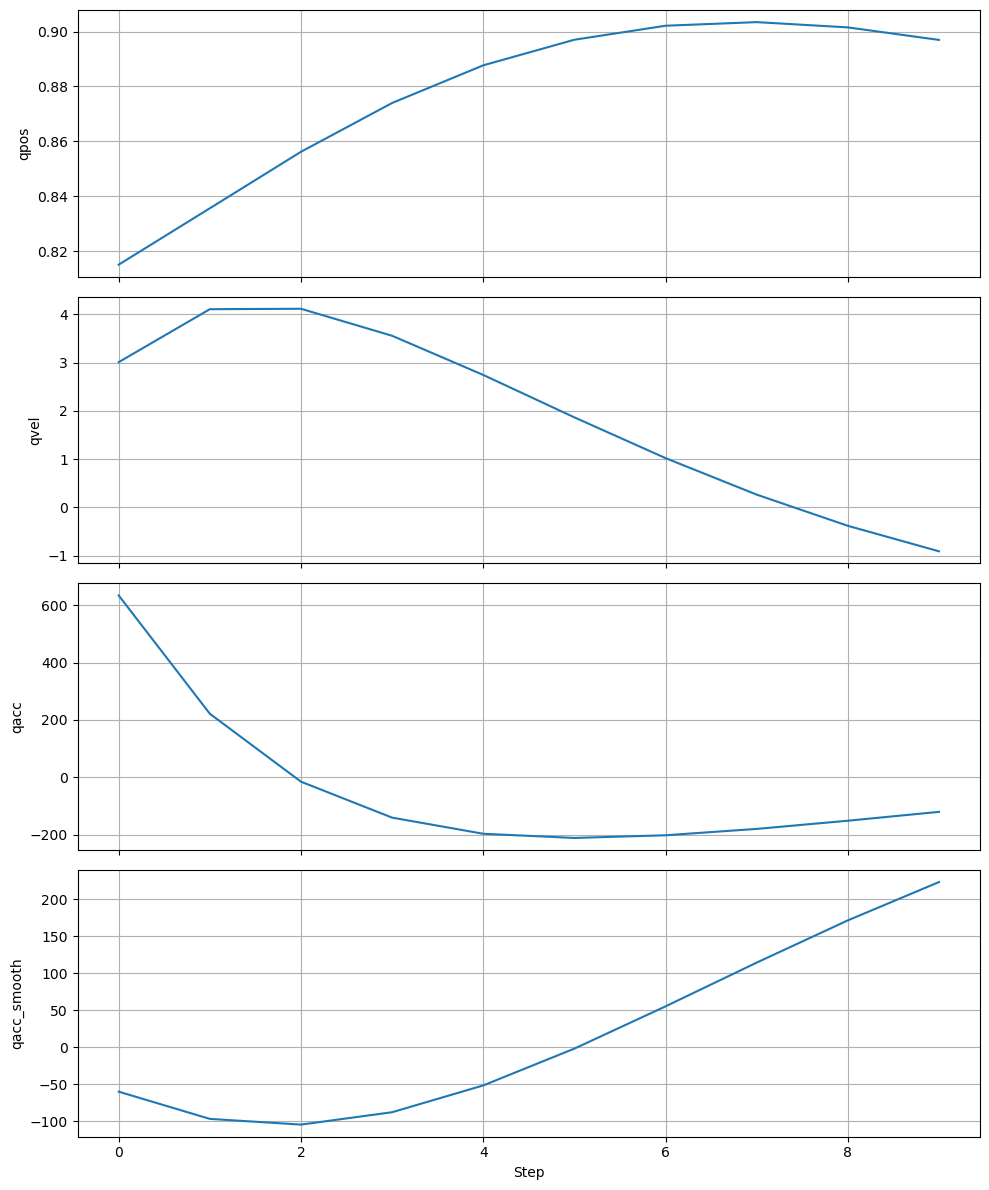

In [62]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
labels = ['qpos', 'qvel', 'qacc', 'qacc_smooth']

for i, key in enumerate(labels):
    axs[i].plot(data[key][:10])
    axs[i].set_ylabel(key)
    axs[i].grid(True)

axs[-1].set_xlabel('Step')
plt.tight_layout()
plt.show()

In [ ]:
for i in range(model.model.njnt):
    print(i, mujoco.mj_id2name(model.model, mujoco.mjtObj.mjOBJ_JOINT, i))

0 sternoclavicular_r2
1 sternoclavicular_r3
2 unrotscap_r3
3 unrotscap_r2
4 acromioclavicular_r2
5 acromioclavicular_r3
6 acromioclavicular_r1
7 unrothum_r1
8 unrothum_r3
9 unrothum_r2
10 elv_angle
11 shoulder_elv
12 shoulder1_r2
13 shoulder_rot
14 elbow_flexion
15 pro_sup
16 deviation
17 flexion
18 cmc_abduction
19 cmc_flexion
20 mp_flexion
21 ip_flexion
22 mcp2_flexion
23 mcp2_abduction
24 pm2_flexion
25 md2_flexion
26 mcp3_flexion
27 mcp3_abduction
28 pm3_flexion
29 md3_flexion
30 mcp4_flexion
31 mcp4_abduction
32 pm4_flexion
33 md4_flexion
34 mcp5_flexion
35 mcp5_abduction
36 pm5_flexion
37 md5_flexion


In [ ]:
plt.figure(figsize=(6, 5))
plt.imshow(M[], cmap='viridis')
plt.colorbar(label='Mass Matrix Entry')
plt.title('Mass Matrix M(q)')
plt.xlabel('Joint index (j)')
plt.ylabel('Joint index (i)')
plt.show()

In [8]:
def find_stiffness(q):
    spec = mujoco.mjtState.mjSTATE_INTEGRATION
    size = mujoco.mj_stateSize(model.model, spec) 
    mujoco.mj_setState(model.model, model.data, state1, spec)
    
    torque = [2,-10,-1,2]
    torque = np.array(torque)

    for i in range(len(model.joint_names)):
        model.data.qpos[model.model.joint(model.joint_names[i]).qposadr] = q[i]
        model.data.qvel[model.model.joint(model.joint_names[i]).qposadr] = 0
        model.data.qacc[model.model.joint(model.joint_names[i]).qposadr] = 0

    mujoco.mj_forward(model.model, model.data)

    spec = mujoco.mjtState.mjSTATE_INTEGRATION
    size = mujoco.mj_stateSize(model.model, spec)
    state0 = np.empty(size, np.float64)
    
    mujoco.mj_getState(model.model, model.data, state0, spec)

    mujoco.mj_inverse(model.model, model.data)
    
    torque = np.array([model.data.qfrc_inverse[id][0] for id in model.joint_id_list])
    torque[0] = -2
    torque[3] = 2
        
    activations, err, success, t, achieved_torque = model.optimize_fast(req_torques=torque)
    k, jac, fm, km = model.stiffness()
    print("Stiffness: ", [k[0,0],k[1,1],k[2,2],k[3,3]])
    print("Achieved torque: ", achieved_torque)
    print("Reqd torque = ", torque)

    # k = np.array([[2.22612592e+01 -1.03751631e+01 -4.63603935e+00  7.32344336e-01],[-1.03751631e+01  5.75668051e+01  2.50795380e+00  2.96334339e-01],[-4.63603935e+00  2.50795380e+00  4.28175375e+00  8.00523337e-03],[ 7.32344336e-01  2.96334339e-01  8.00523337e-03  1.00387523e+01]])
    # k = np.array([[22, -10.3, -4.6, 0.73], [-10.3, 57, 2.5, 0.296], [-4.63, 2.5, 4.28, 0.008], [0.73, 0.296, 0.008, 5*10]])
    mujoco.mj_setState(model.model, model.data, state0, spec)

    ctrl = model.data.ctrl
                
    for idx, act in zip(model.muscle_ids, activations):
        ctrl[idx] = act

    model.data.ctrl = ctrl

    body_name = "lunate"  
    body_id = model.model.body(name=body_name).id

    jacp = np.zeros((3, model.model.nv))  
    jacr = np.zeros((3, model.model.nv))  

    mujoco.mj_jacBodyCom(model.model, model.data, jacp, jacr, body_id)

    J = jacp
    # J = np.vstack((jacp, jacr)) 
    J = J[:, model.joint_id_list]
    J = J[:,:,0]
    
    J_plus = J.T @ np.linalg.inv(J @ J.T)

    K_end = J_plus.T @ k @ J_plus
    K_end = K_end[:3,:3]
    return K_end, k, activations, success, jac, fm, km

In [9]:
sh_arr = [0.2, 0.4, 0.5, 0.7, 1.0, 1.2, 1.4, 1.6, 1.8]
el_arr = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

q_arr = []
for i in sh_arr:
    for j in el_arr:
        q_arr.append([i, 1.57, 0.2, j])

In [10]:
print(q_arr)

[[0.2, 1.57, 0.2, 0.4], [0.2, 1.57, 0.2, 0.6], [0.2, 1.57, 0.2, 0.8], [0.2, 1.57, 0.2, 1.0], [0.2, 1.57, 0.2, 1.2], [0.2, 1.57, 0.2, 1.4], [0.2, 1.57, 0.2, 1.6], [0.2, 1.57, 0.2, 1.8], [0.2, 1.57, 0.2, 2.0], [0.4, 1.57, 0.2, 0.4], [0.4, 1.57, 0.2, 0.6], [0.4, 1.57, 0.2, 0.8], [0.4, 1.57, 0.2, 1.0], [0.4, 1.57, 0.2, 1.2], [0.4, 1.57, 0.2, 1.4], [0.4, 1.57, 0.2, 1.6], [0.4, 1.57, 0.2, 1.8], [0.4, 1.57, 0.2, 2.0], [0.5, 1.57, 0.2, 0.4], [0.5, 1.57, 0.2, 0.6], [0.5, 1.57, 0.2, 0.8], [0.5, 1.57, 0.2, 1.0], [0.5, 1.57, 0.2, 1.2], [0.5, 1.57, 0.2, 1.4], [0.5, 1.57, 0.2, 1.6], [0.5, 1.57, 0.2, 1.8], [0.5, 1.57, 0.2, 2.0], [0.7, 1.57, 0.2, 0.4], [0.7, 1.57, 0.2, 0.6], [0.7, 1.57, 0.2, 0.8], [0.7, 1.57, 0.2, 1.0], [0.7, 1.57, 0.2, 1.2], [0.7, 1.57, 0.2, 1.4], [0.7, 1.57, 0.2, 1.6], [0.7, 1.57, 0.2, 1.8], [0.7, 1.57, 0.2, 2.0], [1.0, 1.57, 0.2, 0.4], [1.0, 1.57, 0.2, 0.6], [1.0, 1.57, 0.2, 0.8], [1.0, 1.57, 0.2, 1.0], [1.0, 1.57, 0.2, 1.2], [1.0, 1.57, 0.2, 1.4], [1.0, 1.57, 0.2, 1.6], [1.0, 1.57

In [11]:
print(model.model.jnt_range[model.joint_id_list])

[[[-1.658  2.269]]

 [[ 0.     3.142]]

 [[-1.571  2.094]]

 [[ 0.     2.269]]]


In [12]:
random_torq_data = {"q": q_arr, "tau": np.empty((len(q_arr),10000,4)), "act": np.empty((len(q_arr),10000,23))}

with mujoco.viewer.launch_passive(model.model, model.data) as viewer:
    viewer.opt.frame = mujoco.mjtFrame.mjFRAME_WORLD

    for n,q in enumerate(q_arr):
        spec = mujoco.mjtState.mjSTATE_INTEGRATION
        size = mujoco.mj_stateSize(model.model, spec) 
        mujoco.mj_setState(model.model, model.data, state1, spec)
        
        for i in range(len(model.joint_names)):
            model.data.qpos[model.model.joint(model.joint_names[i]).qposadr] = q[i]
            model.data.qvel[model.model.joint(model.joint_names[i]).qposadr] = 0
            model.data.qacc[model.model.joint(model.joint_names[i]).qposadr] = 0

        mujoco.mj_forward(model.model, model.data)

        spec = mujoco.mjtState.mjSTATE_INTEGRATION
        size = mujoco.mj_stateSize(model.model, spec)
        state0 = np.empty(size, np.float64)
        
        mujoco.mj_getState(model.model, model.data, state0, spec)

        # jac = model.data.ten_J
        # jac_1 = []

        # for i in range(model.model.na):
        #         if i in model.muscle_ids:
        #             jac_1.append([])
        #             for j in range(model.model.nq):
        #                 if j in model.joint_id_list:
        #                     jac_1[-1].append(jac[i + 4, j])       

        # jac_1 = np.array(jac_1)

        # M, c = model.linearize()
        
        # A = jac_1.T @ M
        # C = jac_1.T @ c

        print(n)
        for i in range(100):
            mujoco.mj_setState(model.model, model.data, state0, spec)
            act = np.random.rand(23)
            for id, a in zip(model.muscle_ids, act):
                model.data.ctrl[id] = a
            for _ in range(10):
                mujoco.mj_step(model.model, model.data)    
            random_torq_data['act'][n,i,:] = act
            torq = [model.data.qfrc_actuator[model.elv_angle_id][0], model.data.qfrc_actuator[model.shoulder_elv_id][0], model.data.qfrc_actuator[model.rot_id][0], model.data.qfrc_actuator[model.elbow_id][0]]
            random_torq_data['tau'][n,i,:] = torq
            viewer.sync()
            time.sleep(0.1)
        
        print("q: ", random_torq_data['q'][n])
        print("Tau max: ", [max(random_torq_data['tau'][n,:,j]) for j in range(4)])
        print("Tau min: ", [min(random_torq_data['tau'][n,:,j]) for j in range(4)])

0


KeyboardInterrupt: 

In [8]:
for i in range(len(q_arr)):
    print("q: ", random_torq_data['q'][i])
    print("Tau max: ", [max(random_torq_data['tau'][i,:,j]) for j in range(4)])
    print("Tau min: ", [min(random_torq_data['tau'][i,:,j]) for j in range(4)])

q:  [0.2, 1.57, 0.4, 0.4]
Tau max:  [79.97706253304527, 38.88439158569068, 1.456053292199562, 11.936816477876665]
Tau min:  [-12.727901596327806, -50.370900945574334, -34.428312596759625, -27.34541186215555]
q:  [0.2, 1.57, 0.4, 0.6]
Tau max:  [79.64010570269443, 36.505561829259534, 0.5308767592880171, 11.839618170164176]
Tau min:  [-10.465826489311466, -50.8605339537162, -37.309485663248374, -22.748497580771346]
q:  [0.2, 1.57, 0.4, 0.8]
Tau max:  [80.87182645582908, 42.19799004580913, 2.171364201027403, 13.181077532203494]
Tau min:  [-20.61939155279638, -45.22800176931707, -39.68519200006275, -23.11877304488354]
q:  [0.2, 1.57, 0.4, 1.0]
Tau max:  [81.56943102597748, 38.486715939468766, 0.0, 13.64540010560489]
Tau min:  [-20.131882138194708, -48.041660098917966, -43.57552092109565, -24.42017813082705]
q:  [0.2, 1.57, 0.4, 1.2]
Tau max:  [73.10810505655007, 41.36467557465319, 0.6636514146709654, 18.933885778243187]
Tau min:  [-13.721765389520595, -52.356163649918585, -45.1765532440574

In [73]:
# Configuration
num_rows = len(q_arr)          # Number of row groups
num_rows = 20
num_cols = 4          # 4 scatter plots per row
points_per_plot = 10000

# Create subplot grid
fig = make_subplots(
    rows=num_rows, cols=num_cols, shared_xaxes= True,
    subplot_titles=[f"Position {q}" for q in q_arr for _ in range(4)]
)

# Add scatter plots
for row in range(num_rows):
    for col in range(num_cols):
        fig.add_trace(
            go.Scattergl(y=np.sort(random_torq_data['tau'][row, :, col]), mode='markers', marker=dict(size=2), name=f"Row {row+1} Col {col+1}"),
            row=row + 1, col=col + 1,
        )
        fig.update_yaxes(range = [-100, 100], row = row + 1, col = col + 1)

fig.update_layout(
    height=350 * num_rows,
    width=1200,
    title="Torques",
    showlegend=False
)

fig.show()

In [ ]:
data = {'Kq': [], 'Ke': [], 'Km': [], 'el_pos': [], 'wrist_pos': [], 'error': [], 'act': [], 'Jm': [], 'muscle_forces': []}

with mujoco.viewer.launch_passive(model.model, model.data) as viewer:
    viewer.opt.frame = mujoco.mjtFrame.mjFRAME_WORLD

    # for _ in range(100):
    #     mujoco.mj_step(model.model, model.data)
    for i in range(len(q_arr)):
        # try:
        k, k_q, act, err, Jm, fm, km = find_stiffness(q_arr[i])
        # except:
        #     print('error')
        viewer.sync()
        
        body_name = "lunate"  
        body_id = model.model.body(name=body_name).id
        wrist_pos = model.data.xpos[body_id]
        
        elbow_site = "TRI_site_BRA_side"
        site_id = mujoco.mj_name2id(model.model, mujoco.mjtObj.mjOBJ_SITE, elbow_site)
        elbow_pos = model.data.site_xpos[site_id]

        data['Kq'].append(k_q)
        data['Ke'].append(k)
        data['el_pos'].append([elbow_pos[0], elbow_pos[1]])
        data['wrist_pos'].append([wrist_pos[0], wrist_pos[1]])
        data['error'].append(err)
        data['act'].append(act)
        data['Jm'].append(Jm)
        data['muscle_forces'].append(fm)
        data['Km'].append(km)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03006288748022392
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization took 2.737609 ms
Constraint 0 (eq): residual = [-2.         -5.01288322 -0.25231909  2.        ]
Stiffness:  [34.72809553481738, 12.278226761739658, 0.6106387698805628, 18.736096287871963]
Achieved torque:  [-2.017486605377547, -5.058213831957058, -0.23665446701278445, 2.146531022930258]
Reqd torque =  [-2.         -5.01288322 -0.25231909  2.        ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06795218950440629
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization took 1.77956 ms
Constraint 0 (eq): residual = [-2.         -5.3159707  -0.19162393  2.        ]
Stiffness:  [47.019205937867255, 16.507056312467466, 0.83427306567141, 24.44333064163151]
Achieved torque:  

In [8]:
pio.renderers.default = 'browser'

fig = go.Figure()
res = 30
t = np.linspace(0, 2*np.pi, res)
x = np.cos(t)
y = np.sin(t)       
circle = np.vstack((x,y))

for i in range(len(data['Ke'])):
    if data['error'][i]:
        k_e = data['Ke'][i]
        eigvals, eigvecs = np.linalg.eigh(k_e[:2, :2])
        ellipsoid = eigvecs @ np.diag(eigvals) @ circle
        ellipsoid[0,:] = (ellipsoid[0,:])/5e4 + data['wrist_pos'][i][0]
        ellipsoid[1,:] = (ellipsoid[1,:])/5e4 + data['wrist_pos'][i][1]
        
        fig.add_trace(go.Scatter(x=ellipsoid[0,:], y=ellipsoid[1,:]))
        fig.add_trace(go.Scatter(x = [0, data['el_pos'][i][0]], y = [0, data['el_pos'][i][1]], mode='lines', line=dict(color='rgba(0,255,0,0.3)', width=0.5)))
        fig.add_trace(go.Scatter(x = [data['el_pos'][i][0], data['wrist_pos'][i][0]], y = [data['el_pos'][i][1], data['wrist_pos'][i][1]], mode='lines', line=dict(color='rgba(0,0,255,0.3)', width=0.5)))

fig.update_layout(
    width= 800,
    height = 800,
    title = "Endpoint ellipses",
    xaxis=dict(scaleanchor = 'y', range = [-0.8, 0.2]),
    yaxis=dict(range = [-0.8, 0.2]),
)

fig.show()


In [ ]:
# Create subplots: each chart in its own row
fig2 = make_subplots(rows=len(data['muscle_forces']), cols=3, subplot_titles= ("Force", "Activations", "Muscle Stiffness"))

# Add bar charts to each row
for i in range(len(data['muscle_forces'])):
    # if data['error'][i]:
    fig2.add_trace(
        go.Bar(x=model.muscle_names, y=data['muscle_forces'][i]),
        row=i+1, col=1
    )
    fig2.update_yaxes(range=[0, 1000], row=i+1, col=1) 
    fig2.add_trace(
        go.Bar(x=model.muscle_names, y=data['act'][i]),
        row=i+1, col=2
    )
    fig2.update_yaxes(range=[0, 1], row=i+1, col=2) 
    fig2.add_trace(
        go.Bar(x = model.muscle_names, y = data['Km'][i]),
        row = i+1, col = 3
    )
    fig2.update_yaxes(range=[0, 100000], row=i+1, col=3) 

# annotations = []
# for i in range(len(data['muscle_forces'])):
#     annotations.append(dict(
#         x = 0,
#         y = 1 - (i + 0.5)/len(data['muscle_forces']),
#         text = f"Position: {q_arr[i]}, Error: {data['error'][i]}",
#     ))
# Layout adjustments
fig2.update_layout(
    height=300 * len(data['muscle_forces']),  # Height scales with number of charts
    title="Forces and activations",
    showlegend=False,
    margin = dict(l = 100)
)

fig2.show()

Test for muscle activation finding

In [19]:
model.model.opt.timestep = 0.005
print(model.model.opt.timestep)

0.005


In [109]:
# q = [1.59, 0.5, 0.1, 0.8]
q = [0,0,0,0]

for i in range(len(model.joint_names)):
    model.data.qpos[model.model.joint(model.joint_names[i]).qposadr] = q[i]
    model.data.qvel[model.model.joint(model.joint_names[i]).qposadr] = 0
    model.data.qacc[model.model.joint(model.joint_names[i]).qposadr] = 0

In [110]:
spec = mujoco.mjtState.mjSTATE_INTEGRATION
size = mujoco.mj_stateSize(model.model, spec)
state2 = np.empty(size, np.float64)
mujoco.mj_getState(model.model, model.data, state2, spec)

In [ ]:
n = 2
lin_arr = []

mujoco.mj_setState(model.model, model.data, state2, spec)

for m_id in model.muscle_ids:
    model.data.ctrl[m_id] = 0.5

for _ in range(n):
    mujoco.mj_step(model.model, model.data)

jac = model.data.ten_J
jac_1 = []
# joint_id_list = [model.shoulder_elv_id, model.elv_angle_id, model.rot_id, model.elbow_id]

for i in range(model.model.na):
    if i in model.muscle_ids:
        jac_1.append([])
        for j in range(model.model.nq):
            if j in model.joint_id_list:
                jac_1[-1].append(jac[i + 4, j])

jac_1 = np.array(jac_1)

a1 = np.array([model.data.act[m_id] for m_id in model.muscle_ids])
f1 = np.array([model.data.actuator_force[m_id] for m_id in model.muscle_ids])
tau1 = np.array([model.data.qfrc_actuator[j_id] for j_id in model.joint_id_list])

mujoco.mj_setState(model.model, model.data, state2, spec)

for m_id in model.muscle_ids:
    model.data.ctrl[m_id] = 0.2

for _ in range(n):
    mujoco.mj_step(model.model, model.data)

a2 = np.array([model.data.act[m_id] for m_id in model.muscle_ids])
f2 = np.array([model.data.actuator_force[m_id] for m_id in model.muscle_ids])
tau2 = np.array([model.data.qfrc_actuator[j_id] for j_id in model.joint_id_list])

m = (f2 - f1)/(a2 - a1)
M = np.diag(m)
c = f1 - M @ a1

# print(M, c)

print("f2: ", f2)
print("Calc f2: ", M @ a2 + c)

print("f1: ", f1)
print("Calc f1: ", M @ a1 + c)

mujoco.mj_setState(model.model, model.data, state2, spec)

for m_id in model.muscle_ids:
    model.data.ctrl[m_id] = 0.05

for _ in range(n):
    mujoco.mj_step(model.model, model.data)

a3 = np.array([model.data.act[m_id] for m_id in model.muscle_ids])
f3 = np.array([model.data.actuator_force[m_id] for m_id in model.muscle_ids])
tau3 = np.array([model.data.qfrc_actuator[j_id] for j_id in model.joint_id_list])

print("f3: ", f3)
print("Calc f3: ", M @ a3 + c)

print("tau1: ", tau1)
print("Calc tau1: ", jac_1.T @ M @ a1 + jac_1.T @ c)

f2:  [-278.41972817 -669.50226807  -22.61576009 -114.40469846 -367.79091234
 -269.61536772  -85.18290198  -36.13330905  -93.76877605  -50.18395683
   -4.08189195  -93.29479744   -6.65170741  -24.7075687  -154.78929094
  -64.0588236   -40.4917086    -0.79945592  -54.91914735 -184.12614813
  -51.96772596 -414.53563088 -169.02545045]
Calc f2:  [-278.41972817 -669.50226807  -22.61576009 -114.40469846 -367.79091234
 -269.61536772  -85.18290198  -36.13330905  -93.76877605  -50.18395683
   -4.08189195  -93.29479744   -6.65170741  -24.7075687  -154.78929094
  -64.0588236   -40.4917086    -0.79945592  -54.91914735 -184.12614813
  -51.96772596 -414.53563088 -169.02545045]
f1:  [-469.95026358 -785.14924797  -43.81803517 -217.96131297 -712.59489266
 -521.51677764 -165.04187259  -70.00828628 -152.00487233  -97.23141637
   -7.90866565 -180.75867004  -12.8876831   -47.87091436 -299.9042512
 -124.11397073  -78.45268542   -1.54894585 -104.61054723 -249.34875039
 -100.68746905 -616.53976238 -193.1042857

In [121]:
print(M,c)

[[ -799.63276324     0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.        ]
 [    0.          -482.82178032     0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.        ]
 [    0.             0.           -88.518699       0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.             0.             0.        ]
 [    0.             0.             0.        

In [23]:
np.set_printoptions(threshold=np.inf)
print(model.data.ten_J[20])
print(model.elv_angle_id, model.shoulder_elv_id, model.rot_id, model.elbow_id)

[ 1.54498810e-18  1.75640752e-17  1.75640752e-17  6.77626358e-19
 -5.20417043e-18  8.67361738e-19  3.03576608e-18 -4.98732999e-18
 -1.88109077e-17  1.02999206e-18  3.18484388e-18  1.53956708e-17
 -5.42101086e-20 -7.58941521e-19  2.01334493e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[10] [11] [13] [14]


In [24]:
for i, n in zip(model.muscle_ids, model.muscle_names):
    print(i, n)

0 DELT1
1 DELT2
2 DELT3
3 SUPSP
4 INFSP
5 SUBSC
6 TMIN
7 TMAJ
8 PECM1
9 PECM2
10 PECM3
12 LAT2
13 LAT3
14 CORB
15 TRIlong
16 TRIlat
17 TRImed
18 ANC
19 SUP
20 BIClong
21 BICshort
22 BRA
23 BRD


In [25]:
mujoco.mj_setState(model.model, model.data, state2, spec)

model.data.qpos[model.elbow_id] = 0.0

mujoco.mj_step1(model.model, model.data)
mujoco.mj_fwdActuation(model.model, model.data)

j_id = model.elbow_id
print(model.data.qfrc_actuator[j_id])
# print(model.data.qpos)

mujoco.mj_setState(model.model, model.data, state2, spec)
model.data.qpos[model.elbow_id] = 1.0
# model.data.ctrl[20] = 0.2
mujoco.mj_step1(model.model, model.data)

print(model.data.actuator_force)
mujoco.mj_fwdActuation(model.model, model.data)

print(model.data.qfrc_actuator)

# print(model.data.actuator_force)
print("Force calc")
print(model.data.ten_J[4:][:].T @ model.data.actuator_force)
# print(model.data.qfrc_actuator)

[3.93841156]
[-7.37865736e+01 -5.60651538e+02  0.00000000e+00 -1.99421882e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.80178485e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.43957237e+00
 -1.02699488e+02 -4.86569755e-04 -1.93229162e+02 -1.42229717e+02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.28633947e-02
  0.00000000e+00  0.00000000e+00 -1.02661574e-01  0.00000000e+00
  0.00000000e+00 -1.86879814e-01  0.00000000e+00  0.00000000e+00
  0.00000000